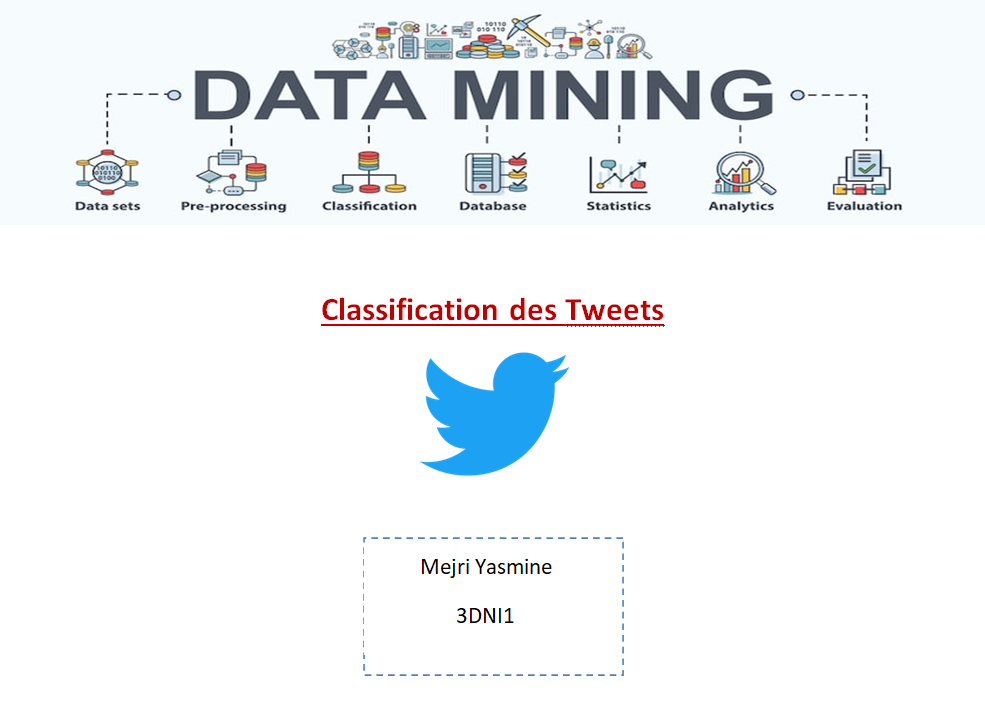

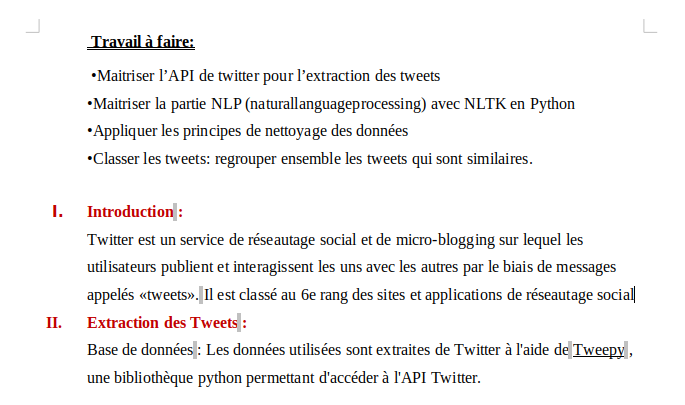

#### 1) Maitriser l’API de twitter pour l’extraction des tweets



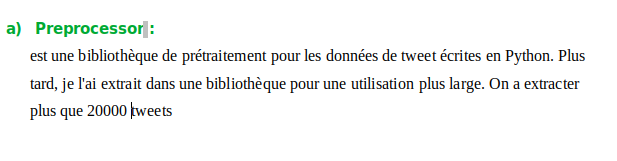

In [1]:
!pip install preprocessor
import preprocessor as p


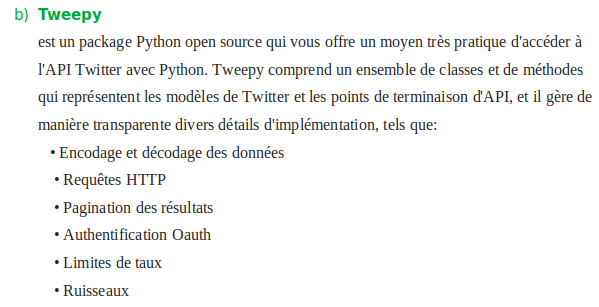

In [2]:
!pip install tweepy
import tweepy

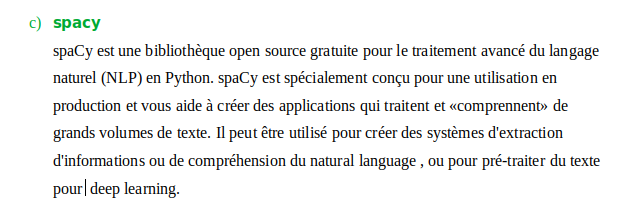

In [3]:
!pip install -U spacy
!python3 -m spacy download en_core_web_sm
import spacy

Requirement already up-to-date: spacy in /home/yasmine/anaconda3/lib/python3.7/site-packages (2.3.5)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


### importer les bibliotheques necessaires

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from typing import List
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yasmine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yasmine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Création des informations d'authentification de l'API Twitter

### Étape 1: demander un compte de développeur Twitter


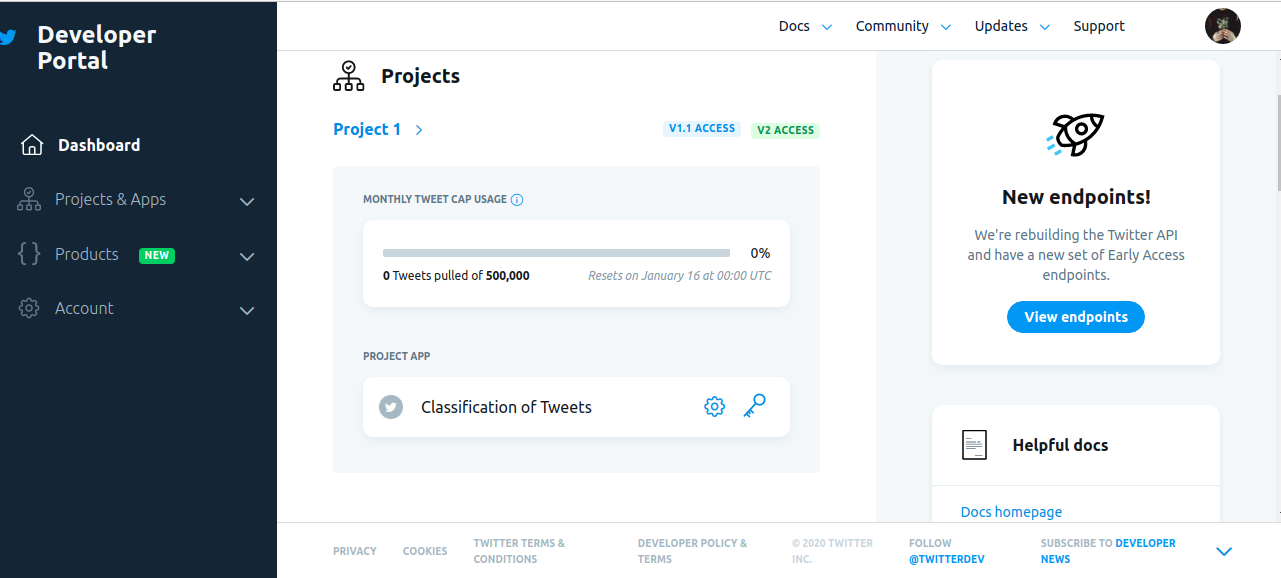

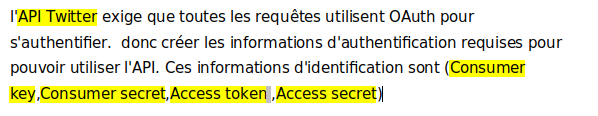

In [ ]:
# Add your Twitter API credentials
consumer_key = "iuoxy4jNIgJg3hd9MMjOjMqNs" 
consumer_secret = "6inhY4mQw9tp08xP7iTihVYj1wMtA2rAW3vCf6pxK2JLQHLN3r"
access_key = "1015771879-TZ3kFtK5m8Nt0OZThTOcsYkUDu206QaXdZfFdhb"
access_secret = "pMO7jAszm1oqCGwJfHVHnZpFnaDkPHWijfKZlP99opzDY"

# Handling authentication with Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)

# Create a wrapper for the API provided by Twitter
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

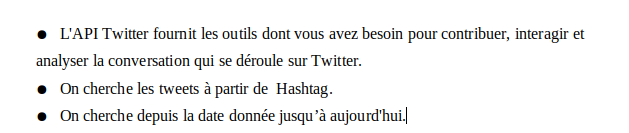

In [ ]:
# Define the search term to make the search
search_words = "#"
# Exclude retweets in our search
new_search = search_words + " -filter:retweets"

date_since = "2020-12-10"

# Define until what date we are looking for tweets
date_until = ""

# Total tweets to gather in our search
totalTweets = 100000

# Numbers of tweets to return per page, max is 100. Default is 15.
count = 100

# Filter by language
lang = "en"

geocode = ""

# Filter by recent, popular or mixed.
result_type = "recent"


In [ ]:

'''Include info on entities found in Tweets, including hashtags,
links, and mentions. Set to True or False'''
include_entities = True

# Set the name for CSV file  where the tweets will be saved
filename = "Twitter"


# Function for handling pagination in our search
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            print('Reached rate limite. Sleeping for >15 minutes')
            time.sleep(15 * 61)


# Function for make the search using Twitter API
def search_tweets(new_search, date_since):

    # performs the search using the defined variables
    for tweet in limit_handled(tweepy.Cursor(api.search,
                               q=new_search,
                               count=count,
                               tweet_mode='extended',
                               lang=lang,
                               geocode=geocode,
                               result_type=result_type,
                               include_entities=include_entities,
                               since=date_since,
                               until=date_until).items(totalTweets)):

        try:

            # Checks if its a extended tweet (>140 characters)
            content = tweet.full_text

            '''Convert all named and numeric character references
            (e.g. &gt;, &#62;, &#x3e;) in the string s to the
            corresponding Unicode characters'''
            content = (content.replace('&amp;', '&').replace('&lt;', '<')
                       .replace('&gt;', '>').replace('&quot;', '"')
                       .replace('&#39;', "'").replace(';', " ")
                       .replace(r'\u', " ").replace('\u2026', ""))


In [ ]:

            # Save other information from the tweet
            user = tweet.author.screen_name
            timeTweet = tweet.created_at
            source = tweet.source
            tweetId = tweet.id
            tweetUrl = "https://twitter.com/statuses/" + str(tweetId)

            # Exclude retweets, too many mentions and too many hashtags
            if not any((('RT @' in content, 'RT' in content,
                       content.count('@') >= 2, content.count('#') >= 3))):

                # Saves the tweet information in a new row of the CSV file
                writer.writerow([content, timeTweet,
                                user, source, tweetId, tweetUrl])

        except Exception as e:
            print('Encountered Exception:', e)
            pass




In [ ]:
def work():

    # Opening a CSV file to save the gathered tweets
    with open(filename+".csv", 'w') as file:
        global writer
        writer = csv.writer(file)

        # Add a header row to the CSV
        writer.writerow(["Contenu_", "Date_", "Utilisateur_",
                         "Source_", "ID_", "Tweet URL"])

        # Initializing the Twitter search
        try:
            search_tweets(search_words, date_since)

        # Stop temporarily when hitting Twitter rate Limit
        except tweepy.RateLimitError:
            print("RateLimitError...waiting ~15 minutes to continue")
            time.sleep(1001)
            search_tweets(search_words, date_since)

        # Stop temporarily when getting a timeout or connection error
        except (Timeout, ssl.SSLError, ReadTimeoutError,
                ConnectionError) as exc:
            print("Timeout/connection error...waiting ~15 minutes to continue")
            time.sleep(1001)
            search_tweets(search_words, date_since)

        # Stop temporarily when getting other errors
        except tweepy.TweepError as e:
            if 'Failed to send request:' in e.reason:
                print("Time out error caught.")
                time.sleep(1001)
                search_tweets(search_words, date_since)
            elif'Too Many Requests' in e.reason:
                print("Too many requests, sleeping for 15 min")
                time.sleep(1001)
                search_tweets(search_words, date_since)
            else:
                print(e)
                print("Other error with this user...passing")
                pass


if __name__ == '__main__':

    work()

#### Nous utiliserons des pandas pour lire le fichier csv contenant les Tweets . nous allons donc lire le fichier "Twitter.csv".

In [4]:
import pandas as pd

In [5]:
 df = pd.read_csv('Twitter.csv')

#### Utilisez la fonction info () pour imprimer le résumé complet de la trame de données.

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28041 entries, 0 to 28040
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Contenu_      28041 non-null  object
 1   Date_         28041 non-null  object
 2   Utilisateur_  28041 non-null  object
 3   Source_       28033 non-null  object
 4   ID_           28041 non-null  int64 
 5   Tweet URL     28041 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.3+ MB


In [7]:
df.head(1000)


,Contenu_,Date_,Utilisateur_,Source_,ID_,Tweet URL
0,https://t.co/K4ul9x4Idt\nIvan4v added a bet 'K...,2020-12-16 19:06:17,JohnnyBetPicks,johnnybet_picks2,1339285738551189505,https://twitter.com/statuses/1339285738551189505
1,"(5) With true investment, strong leadership, a...",2020-12-16 19:06:17,mariejbeech,Twitter for iPhone,1339285738484011017,https://twitter.com/statuses/1339285738484011017
2,@Popenzpopany1 Weird naa ?,2020-12-16 19:06:17,MissFries_,Twitter for iPhone,1339285738421170177,https://twitter.com/statuses/1339285738421170177
3,@_Furkan_andic__ we know why he answered kg 😌\...,2020-12-16 19:06:17,miffilu,Twitter for Android,1339285738395983879,https://twitter.com/statuses/1339285738395983879
4,i made this because i saw that bambam fic fest...,2020-12-16 19:06:17,softbotsobs,Twitter Web App,1339285738349879304,https://twitter.com/statuses/1339285738349879304
...,...,...,...,...,...,...
995,@mellowstans a feeling lol,2020-12-16 19:06:15,dayguccii,Twitter for iPhone,1339285731810959362,https://twitter.com/statuses/1339285731810959362
996,@disneywifee Oh it’s super cute. You’d probabl...,2020-12-16 19:06:15,MamaBearBSN,Twitter for iPhone,1339285731789987840,https://twitter.com/statuses/1339285731789987840
997,And all that I got\nand all that I need\nI tie...,2020-12-16 19:06:15,jnewsombot,joannanewsombot,1339285731785793536,https://twitter.com/statuses/1339285731785793536
998,Me: watches The Crown\nMy brain: let's talk wi...,2020-12-16 19:06:15,Nonisbitch,Twitter for Android,1339285731785789442,https://twitter.com/statuses/1339285731785789442


In [8]:
df.shape

(28041, 6)

In [12]:
df.drop_duplicates(subset='Contenu_',inplace=True)

In [13]:
#First replace all the empty rows with NAN value 
df['Contenu_'].replace('', np.nan, inplace=True)
#Then we drop those rows
df.dropna(subset=['Contenu_'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27975 entries, 0 to 28040
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Contenu_      27975 non-null  object
 1   Date_         27975 non-null  object
 2   Utilisateur_  27975 non-null  object
 3   Source_       27967 non-null  object
 4   ID_           27975 non-null  int64 
 5   Tweet URL     27975 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [14]:
df.shape

(27975, 6)

In [15]:
df = pd.DataFrame(df[['Contenu_', 'Date_','ID_' ]])
df.head()

,Contenu_,Date_,ID_
0,https://t.co/K4ul9x4Idt\nIvan4v added a bet 'K...,2020-12-16 19:06:17,1339285738551189505
1,"(5) With true investment, strong leadership, a...",2020-12-16 19:06:17,1339285738484011017
2,@Popenzpopany1 Weird naa ?,2020-12-16 19:06:17,1339285738421170177
3,@_Furkan_andic__ we know why he answered kg 😌\...,2020-12-16 19:06:17,1339285738395983879
4,i made this because i saw that bambam fic fest...,2020-12-16 19:06:17,1339285738349879304


In [16]:
df.shape


(27975, 3)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27975 entries, 0 to 28040
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Contenu_  27975 non-null  object
 1   Date_     27975 non-null  object
 2   ID_       27975 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 874.2+ KB


 ## Tweets Preprocessing and Cleaning


 ### Removing Twitter Handles (@user)

In [18]:
import re

In [19]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [20]:
# remove twitter handles (@user)
df['handles'] = np.vectorize(remove_pattern)(df['Contenu_'], "@[\w]*")
df.head(1000)

,Contenu_,Date_,ID_,handles
0,https://t.co/K4ul9x4Idt\nIvan4v added a bet 'K...,2020-12-16 19:06:17,1339285738551189505,https://t.co/K4ul9x4Idt\nIvan4v added a bet 'K...
1,"(5) With true investment, strong leadership, a...",2020-12-16 19:06:17,1339285738484011017,"(5) With true investment, strong leadership, a..."
2,@Popenzpopany1 Weird naa ?,2020-12-16 19:06:17,1339285738421170177,Weird naa ?
3,@_Furkan_andic__ we know why he answered kg 😌\...,2020-12-16 19:06:17,1339285738395983879,"we know why he answered kg 😌\nhe said ""tuzak""..."
4,i made this because i saw that bambam fic fest...,2020-12-16 19:06:17,1339285738349879304,i made this because i saw that bambam fic fest...
...,...,...,...,...
995,@mellowstans a feeling lol,2020-12-16 19:06:15,1339285731810959362,a feeling lol
996,@disneywifee Oh it’s super cute. You’d probabl...,2020-12-16 19:06:15,1339285731789987840,Oh it’s super cute. You’d probably love it!! ...
997,And all that I got\nand all that I need\nI tie...,2020-12-16 19:06:15,1339285731785793536,And all that I got\nand all that I need\nI tie...
998,Me: watches The Crown\nMy brain: let's talk wi...,2020-12-16 19:06:15,1339285731785789442,Me: watches The Crown\nMy brain: let's talk wi...


### Removing  URLS,Punctuations, Numbers, and Special Characters,Upcase

In [21]:
# remove special characters, numbers, punctuations
df['Tweet_punct'] = df['handles'].str.replace("http\S*", " ")#remove URL
df['Tweet_punct'] = df['Tweet_punct'].str.replace("[^a-zA-Z#]", " ")# Removing Punctuations, Numbers, and Special Characters
df['Tweet_punct'] = df['Tweet_punct'].str.lower()# Removing Upcase
df['Tweet_punct'] = df['Tweet_punct'].str.replace("[^A-Za-z0-9^,!.\/'+-=]", " ")
df['Tweet_punct'] = df['Tweet_punct'].str.replace(r'#([^\s]+)', "")# remove all hashtags
df['Tweet_punct'] = df['Tweet_punct'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')#remove duplicated words in row
from collections import OrderedDict
df['Tweet_punct'] = (df['Tweet_punct'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))#To remove non-consecutive duplicates, I'd suggest a solution involving the OrderedDict data structure
df['Tweet_punct'] = df['Tweet_punct'].str.replace('[\s]+', ' ')# remove additional whitespaces in tweets
df.head(1000)

,Contenu_,Date_,ID_,handles,Tweet_punct
0,https://t.co/K4ul9x4Idt\nIvan4v added a bet 'K...,2020-12-16 19:06:17,1339285738551189505,https://t.co/K4ul9x4Idt\nIvan4v added a bet 'K...,ivan v added a bet kaa gent waasland beveren w...
1,"(5) With true investment, strong leadership, a...",2020-12-16 19:06:17,1339285738484011017,"(5) With true investment, strong leadership, a...",with true investment strong leadership and pow...
2,@Popenzpopany1 Weird naa ?,2020-12-16 19:06:17,1339285738421170177,Weird naa ?,weird naa
3,@_Furkan_andic__ we know why he answered kg 😌\...,2020-12-16 19:06:17,1339285738395983879,"we know why he answered kg 😌\nhe said ""tuzak""...",we know why he answered kg said tuzak knows ay...
4,i made this because i saw that bambam fic fest...,2020-12-16 19:06:17,1339285738349879304,i made this because i saw that bambam fic fest...,i made this because saw that bambam fic fest t...
...,...,...,...,...,...
995,@mellowstans a feeling lol,2020-12-16 19:06:15,1339285731810959362,a feeling lol,a feeling lol
996,@disneywifee Oh it’s super cute. You’d probabl...,2020-12-16 19:06:15,1339285731789987840,Oh it’s super cute. You’d probably love it!! ...,oh it s super cute you d probably love a big c...
997,And all that I got\nand all that I need\nI tie...,2020-12-16 19:06:15,1339285731785793536,And all that I got\nand all that I need\nI tie...,and all that i got need tie in a knot lay at y...
998,Me: watches The Crown\nMy brain: let's talk wi...,2020-12-16 19:06:15,1339285731785789442,Me: watches The Crown\nMy brain: let's talk wi...,me watches the crown my brain let s talk with ...


### Removing Short Words

In [22]:
df['specif'] = df['Tweet_punct'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head(1000)

,Contenu_,Date_,ID_,handles,Tweet_punct,specif
0,https://t.co/K4ul9x4Idt\nIvan4v added a bet 'K...,2020-12-16 19:06:17,1339285738551189505,https://t.co/K4ul9x4Idt\nIvan4v added a bet 'K...,ivan v added a bet kaa gent waasland beveren w...,ivan added gent waasland beveren with odds pre...
1,"(5) With true investment, strong leadership, a...",2020-12-16 19:06:17,1339285738484011017,"(5) With true investment, strong leadership, a...",with true investment strong leadership and pow...,with true investment strong leadership power i...
2,@Popenzpopany1 Weird naa ?,2020-12-16 19:06:17,1339285738421170177,Weird naa ?,weird naa,weird
3,@_Furkan_andic__ we know why he answered kg 😌\...,2020-12-16 19:06:17,1339285738395983879,"we know why he answered kg 😌\nhe said ""tuzak""...",we know why he answered kg said tuzak knows ay...,know answered said tuzak knows ayfur fandom th...
4,i made this because i saw that bambam fic fest...,2020-12-16 19:06:17,1339285738349879304,i made this because i saw that bambam fic fest...,i made this because saw that bambam fic fest t...,made this because that bambam fest thingy main...
...,...,...,...,...,...,...
995,@mellowstans a feeling lol,2020-12-16 19:06:15,1339285731810959362,a feeling lol,a feeling lol,feeling
996,@disneywifee Oh it’s super cute. You’d probabl...,2020-12-16 19:06:15,1339285731789987840,Oh it’s super cute. You’d probably love it!! ...,oh it s super cute you d probably love a big c...,super cute probably love city midwife nurse mo...
997,And all that I got\nand all that I need\nI tie...,2020-12-16 19:06:15,1339285731785793536,And all that I got\nand all that I need\nI tie...,and all that i got need tie in a knot lay at y...,that need knot your feet have forgot silence c...
998,Me: watches The Crown\nMy brain: let's talk wi...,2020-12-16 19:06:15,1339285731785789442,Me: watches The Crown\nMy brain: let's talk wi...,me watches the crown my brain let s talk with ...,watches crown brain talk with british accent


#### pour bien eliminer les punctuations

In [23]:
string.punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

df['specif'] = df['specif'].apply(lambda x: remove_punct(x))
df.head(1000)

,Contenu_,Date_,ID_,handles,Tweet_punct,specif
0,https://t.co/K4ul9x4Idt\nIvan4v added a bet 'K...,2020-12-16 19:06:17,1339285738551189505,https://t.co/K4ul9x4Idt\nIvan4v added a bet 'K...,ivan v added a bet kaa gent waasland beveren w...,ivan added gent waasland beveren with odds pre...
1,"(5) With true investment, strong leadership, a...",2020-12-16 19:06:17,1339285738484011017,"(5) With true investment, strong leadership, a...",with true investment strong leadership and pow...,with true investment strong leadership power i...
2,@Popenzpopany1 Weird naa ?,2020-12-16 19:06:17,1339285738421170177,Weird naa ?,weird naa,weird
3,@_Furkan_andic__ we know why he answered kg 😌\...,2020-12-16 19:06:17,1339285738395983879,"we know why he answered kg 😌\nhe said ""tuzak""...",we know why he answered kg said tuzak knows ay...,know answered said tuzak knows ayfur fandom th...
4,i made this because i saw that bambam fic fest...,2020-12-16 19:06:17,1339285738349879304,i made this because i saw that bambam fic fest...,i made this because saw that bambam fic fest t...,made this because that bambam fest thingy main...
...,...,...,...,...,...,...
995,@mellowstans a feeling lol,2020-12-16 19:06:15,1339285731810959362,a feeling lol,a feeling lol,feeling
996,@disneywifee Oh it’s super cute. You’d probabl...,2020-12-16 19:06:15,1339285731789987840,Oh it’s super cute. You’d probably love it!! ...,oh it s super cute you d probably love a big c...,super cute probably love city midwife nurse mo...
997,And all that I got\nand all that I need\nI tie...,2020-12-16 19:06:15,1339285731785793536,And all that I got\nand all that I need\nI tie...,and all that i got need tie in a knot lay at y...,that need knot your feet have forgot silence c...
998,Me: watches The Crown\nMy brain: let's talk wi...,2020-12-16 19:06:15,1339285731785789442,Me: watches The Crown\nMy brain: let's talk wi...,me watches the crown my brain let s talk with ...,watches crown brain talk with british accent


### Tokenization

In [25]:
tokenized_tweet = df['specif'].apply(lambda x: x.split())
tokenized_tweet.head(1000)


0      [ivan, added, gent, waasland, beveren, with, o...
1      [with, true, investment, strong, leadership, p...
2                                                [weird]
3      [know, answered, said, tuzak, knows, ayfur, fa...
4      [made, this, because, that, bambam, fest, thin...
                             ...                        
995                                            [feeling]
996    [super, cute, probably, love, city, midwife, n...
997    [that, need, knot, your, feet, have, forgot, s...
998    [watches, crown, brain, talk, with, british, a...
999    [wasn, even, what, thinking, about, really, th...
Name: specif, Length: 1000, dtype: object

### stopwords

In [26]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'herself', 'i', 'y', 'between', "it's", 'doesn', 'won', 'wasn', 'where', 'by', 'aren', 'should', 'when', 'were', 'm', 'off', 'because', "weren't", 'be', 'more', 'with', "she's", 'needn', 'will', 'down', 'your', "wouldn't", 'couldn', 'why', 'was', 'an', 'no', 'had', 'haven', 'then', 'ain', "mustn't", 'him', 'who', "you've", 'own', 'hadn', 'them', 'through', 'too', 'and', 'his', 'what', 'nor', 'ourselves', 'other', 'its', 'yourself', 'you', 'under', 'same', 'yours', "shan't", 'have', 'to', 'which', 'didn', 'so', 'is', 'themselves', 'of', 'not', "won't", 'himself', 'for', "haven't", 'my', 'they', 'ours', 'again', 'doing', 've', 'has', "that'll", 'above', 'here', "you'd", "you're", 'but', "shouldn't", 'hasn', 'are', 'd', 'whom', 'hers', 'her', 'the', 'just', 'he', "don't", 'until', 'does', "you'll", 'been', 'some', 'at', 'll', 'few', "didn't", 'over', 'these', 'do', 'while', "needn't", 'or', 'a', 'being', 'wouldn', 'than', 'itself', 'into', 'don', 'this', 'all', 'theirs', 'their', 'our', 

In [66]:
#add words that aren't in the NLTK stopwords list/Adverbs of frequency in English/Transition Words
new_stopwords = ['what', 'year', 'yayyy', 'sixteen', 'yearold','day' 'weeks', 'week','yes','yeah','dontt','ikkk'
             'omgg','yeahh','lmao','lots','always', 'usually','regularly','normally','often','sometimes','occasionally','fuck','rarely','seldom','never','even','also','therefore','shit']
new_stopwords_list = stop_words.union(new_stopwords)

In [67]:
def remove_stopwords(text):
    #text = [word for word in text if word not in stopword]
    text = [word for word in text if word not in new_stopwords_list]
    return text
    
Tweet_nonstop = tokenized_tweet.apply(lambda x: remove_stopwords(x))#essaie2
Tweet_nonstop.head(1000)

0      [ivan, added, gent, waasland, beveren, odds, p...
1      [true, investment, strong, leadership, power, ...
2                                                [weird]
3      [know, answered, said, tuzak, knows, ayfur, fa...
4      [made, bambam, fest, thingy, main, almost, app...
                             ...                        
995                                            [feeling]
996    [super, cute, probably, love, city, midwife, n...
997    [need, knot, feet, forgot, silence, crept, bon...
998       [watches, crown, brain, talk, british, accent]
999    [thinking, really, think, four, deals, relieve...
Name: specif, Length: 1000, dtype: object

### Stemming and Lammitization¶

In [29]:
ps = nltk.PorterStemmer()
Tweet_stemme = Tweet_nonstop.apply(lambda x: [ps.stem(i) for i in x]) # stemming essaie2

#Tweet_stemme = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x]) # stemming essaie1
Tweet_stemme.head(1000)

0      [ivan, ad, gent, waasland, beveren, odd, predi...
1      [true, invest, strong, leadership, power, impl...
2                                                [weird]
3      [know, answer, said, tuzak, know, ayfur, fando...
4      [made, bambam, fest, thingi, main, almost, app...
                             ...                        
995                                               [feel]
996    [super, cute, probabl, love, citi, midwif, nur...
997    [need, knot, feet, forgot, silenc, crept, bone...
998         [watch, crown, brain, talk, british, accent]
999    [think, realli, think, four, deal, reliev, goo...
Name: specif, Length: 1000, dtype: object

In [30]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text
Tweet_lemmatized = Tweet_stemme.apply(lambda x: lemmatizer(x)) # stemming essaie2
#clean_tweets['Tweet_lemmatized'] = clean_tweets['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
Tweet_lemmatized.head(1000)

0      [ivan, ad, gent, waasland, beveren, odd, predi...
1      [true, invest, strong, leadership, power, impl...
2                                                [weird]
3      [know, answer, said, tuzak, know, ayfur, fando...
4      [made, bambam, fest, thingi, main, almost, app...
                             ...                        
995                                               [feel]
996    [super, cute, probabl, love, citi, midwif, nur...
997    [need, knot, foot, forgot, silenc, crept, bone...
998         [watch, crown, brain, talk, british, accent]
999    [think, realli, think, four, deal, reliev, goo...
Name: specif, Length: 1000, dtype: object

In [31]:
for i in range(len(Tweet_lemmatized)):
    Tweet_lemmatized.iloc[i] = ' '.join(Tweet_lemmatized.iloc[i])
df['Tweet_lemmatized'] = Tweet_lemmatized

WordCloud

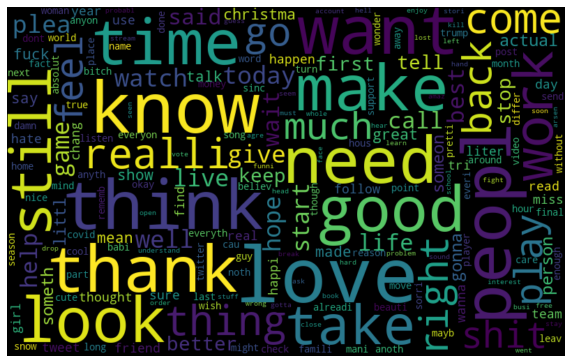

In [32]:
all_words = ' '.join([text for text in df['Tweet_lemmatized']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### TF-IDF Features

In [33]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000, stop_words=new_stopwords_list)
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['Tweet_lemmatized'])

In [71]:
tf_idf_norm = normalize(tfidf)
tf_idf_array = tf_idf_norm.toarray()

vector = pd.DataFrame(tf_idf_array,
                     columns = tfidf_vectorizer.get_feature_names())
vector.head()

,abl,absolut,abus,accept,access,account,achiev,across,act,action,...,worth,would,write,wrong,yall,yellow,yesterday,young,youtub,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296089,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.489152,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
vector.describe()

,abl,absolut,abus,accept,access,account,achiev,across,act,action,...,worth,would,write,wrong,yall,yellow,yesterday,young,youtub,zero
count,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,...,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000,27975.000000
mean,0.001202,0.002429,0.000559,0.000886,0.000495,0.002125,0.000495,0.000504,0.000645,0.000849,...,0.000915,0.007447,0.001297,0.002459,0.001400,0.000613,0.000762,0.000949,0.000881,0.000513
std,0.022800,0.038610,0.016777,0.022007,0.015930,0.033217,0.015987,0.016379,0.019178,0.021859,...,0.023261,0.057487,0.026763,0.038536,0.029254,0.020467,0.021397,0.022858,0.022685,0.017125
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.805471,0.865631,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Model Building

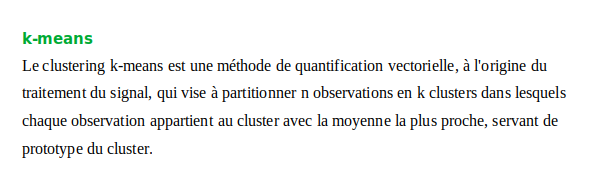

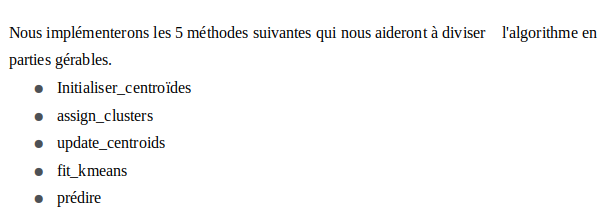

In [73]:
class Kmeans:
    ''' K Means Clustering
    
    Parameters
    -------------------
        k: int, # of clusters
        <
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithms, default: 200
        
    Attributes
    ------------------
        centroids: array, k, number_features
        
        cluster_labels: label for each data point
        
    '''
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter

In [74]:
def intialize_centroids(self,data):
        
        '''Randomly Initialize Centroids
        
        Parameters
        --------------
        data: array or matrix, number_rows, number_features
        
        Returns
        -------------
        centroids: array of k centroids chosen as random data points
        '''
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]
        
        return self.centroids

In [75]:
def assign_clusters(self,data):
        '''Compute distance of data from clusters and assign data point 
        to closest cluster.
        
        Parameters 
        ------------
        data: array or matrix, number_rows, number_features
        
        Returns 
        ------------
        cluster_labels: index which minimizes the distance of data to each cluster
        
        '''
        
        if data.ndim == 1:
            data = data.reshape(-1,1)
            
        dist_to_centroid = pairwise_distances(data,self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return self.cluster_labels
    

In [76]:
 def update_centroids(self,data):
        '''Computes average of all data points in cluster and assigns 
           new centroids as average of data points
           
           Parameters
           -------------
           data: array or matirx, number_rows, number_features
           
           Returns
           -------------
           centroids: array, k, number_features
           '''
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        return self.centroids
    

In [77]:

    
    def fit_kmeans(self, data):
        '''
        This function contains the main loop to fit the algorithm
        Implements initialize centroids and update_centroids according 
        to max_iter
        ---------------------
        
        Returns
        ------------
        instance of kmeans class
        
        '''
        self.centroids = self.intialize_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):
            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)
            if iter % 100 == 0:
                print('Running Model Iteration %d ' %iter)
        print('Model finished running')
        return self

In [78]:
def predict(self,data):
        '''Predict which cluster data point belongs to
        
        Parameters
        --------------
        data: array or matirx, number_rows, number_features
        
        Returns
        -------------
        cluster_labels: index which minimizes the distance of data to each
        cluster
        '''
        
        return self.assign_clusters(data)

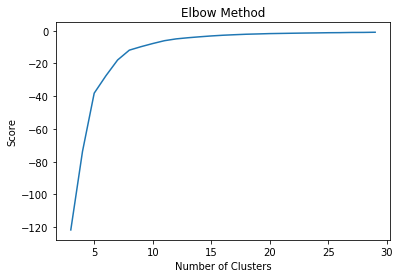

In [79]:
# find out ideal number of clusters using Elbow Method
number_clusters = range(3, 30)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

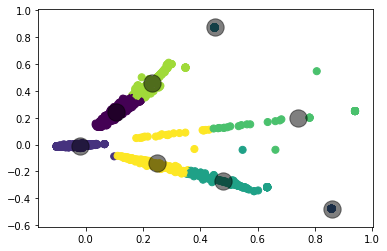

In [80]:
# SKlearn implementation

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=8, max_iter=600, algorithm = 'auto') 
fitted = kmeans.fit(Y_sklearn)
kmeans_prediction = kmeans.predict(Y_sklearn)

skcenters = fitted.cluster_centers_

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=kmeans_prediction, s=50, cmap='viridis')
plt.scatter(skcenters[:, 0], skcenters[:, 1], c='black', s=300, alpha=0.5)

## Extracting top features¶



In [81]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tfidf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

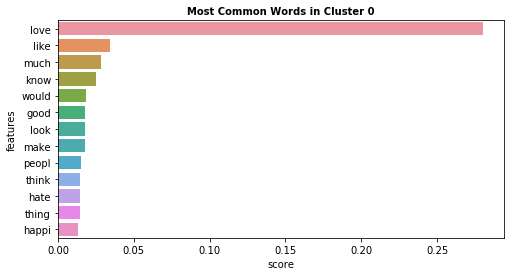

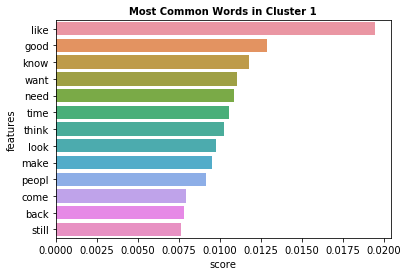

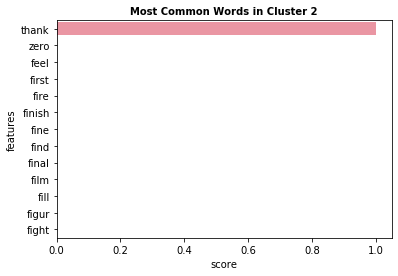

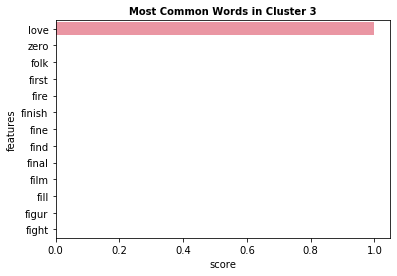

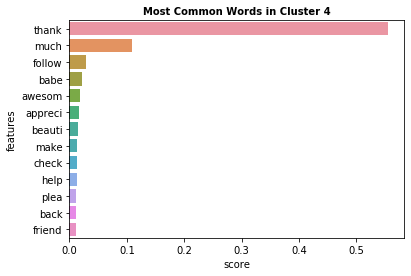

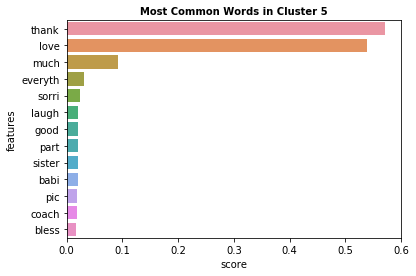

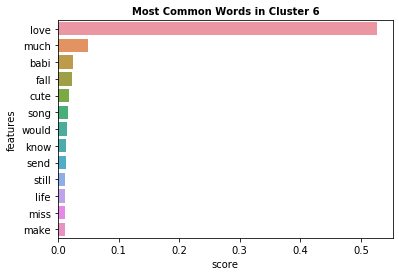

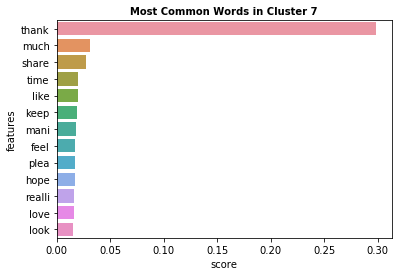

In [82]:
kmeans_dfs = get_top_features_cluster(tf_idf_array, kmeans_prediction, 15)
plotWords(kmeans_dfs, 13)

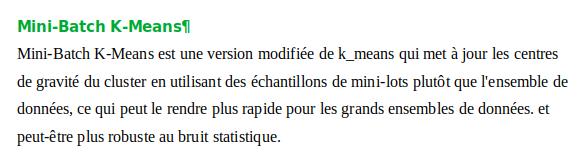

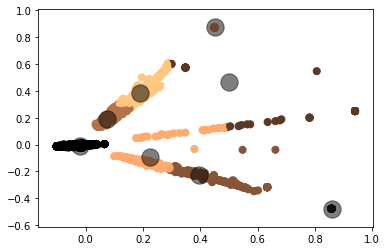

In [83]:
# mini-batch K-Means

from sklearn.cluster import MiniBatchKMeans
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
mbkmeans = MiniBatchKMeans(n_clusters=8, max_iter=400) 
fitted = mbkmeans.fit(Y_sklearn)
prediction = mbkmeans.predict(Y_sklearn)
skcenters = fitted.cluster_centers_
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='copper')
plt.scatter(skcenters[:, 0], skcenters[:, 1], c='black', s=300, alpha=0.5)

In [84]:
words = tfidf_vectorizer.get_feature_names()

In [85]:
print(words[250:300])


['direct', 'discus', 'disgust', 'doctor', 'dollar', 'donat', 'done', 'dont', 'door', 'doubl', 'doubt', 'draw', 'dream', 'dress', 'drink', 'drive', 'drop', 'dude', 'dumb', 'earli', 'easi', 'eat', 'economi', 'edit', 'educ', 'effect', 'effort', 'either', 'el', 'elect', 'email', 'embarrass', 'emot', 'end', 'energi', 'english', 'enjoy', 'enough', 'enter', 'entir', 'episod', 'especi', 'event', 'ever', 'everi', 'everybodi', 'everyday', 'everyon', 'everyth', 'evid']


In [86]:
kmeans = KMeans(n_clusters = 3, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(tf_idf_array)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : love, good, know, need, want, time, think, make, peopl, come, look, back, still, right, would, take, work, plea, realli, well, thing, go, wait, play, ever
1 : thank, much, love, follow, awesom, babe, beauti, appreci, make, help, well, back, anoth, good, famili, plea, christma, friend, great, check, play, give, everyth, keep, nice
2 : like, look, feel, peopl, know, would, want, make, time, realli, sound, love, think, much, someth, play, thing, still, good, girl, need, first, take, game, could


In [88]:
kmeans = KMeans(n_clusters = 5, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : love, much, fall, babi, would, song, snow, thank, hate, send, know, cute, need, want, beauti, best, good, life, first, peopl, thing, realli, ever, wanna, think
1 : need, want, time, think, know, peopl, come, back, right, still, take, plea, would, realli, work, wait, well, play, go, ever, look, today, thing, happi, watch
2 : thank, much, love, follow, babe, awesom, beauti, great, appreci, help, well, christma, back, check, anoth, famili, plea, nice, play, glad, interest, support, last, guy, want
3 : make, sen, like, sure, peopl, feel, look, time, better, think, work, happi, good, would, love, money, want, go, gonna, watch, take, much, life, help, thing
4 : like, good, look, know, feel, peopl, luck, time, would, want, realli, thing, think, sound, night, still, much, play, someth, morn, need, actual, love, first, take


In [89]:
kmeans = KMeans(n_clusters = 8, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : love, know, need, time, think, make, peopl, come, back, right, look, still, plea, would, take, work, well, ever, go, happi, realli, thing, play, today, best
1 : like, look, feel, peopl, know, make, would, time, sound, realli, think, love, thing, someth, still, play, seem, first, girl, take, need, say, game, person, watch
2 : thank, much, love, follow, awesom, babe, beauti, appreci, make, back, anoth, help, plea, friend, great, check, play, well, nice, interest, support, last, said, bless, realli
3 : much, hope, love, thank, time, like, realli, better, feel, would, well, think, soon, help, peopl, make, life, need, hate, know, back, take, work, go, today
4 : want, like, realli, peopl, know, christma, think, give, life, someth, back, work, love, good, anyon, thing, make, come, dont, everyth, take, game, need, trump, play
5 : wanna, make, know, like, look, realli, love, hear, anyon, dont, play, join, snow, home, miss, peopl, right, friend, want, hate, watch, somebodi, give, danc, think

In [90]:
kmeans = KMeans(n_clusters = 10, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : good, luck, night, morn, look, thing, know, time, make, well, life, love, song, pretti, hope, actual, realli, think, news, watch, still, like, one, sound, rest
1 : feel, like, make, better, good, time, today, realli, know, think, hope, peopl, sick, tri, still, day, sorri, much, go, love, would, need, come, ever, person
2 : want, like, realli, christma, peopl, know, life, think, give, love, someth, much, dont, good, make, anyon, get, work, look, trump, plea, still, join, without, start
3 : ignor, messag, answer, busi, day, read, someon, could, start, figur, felt, field, fight, zero, fill, film, fell, find, fine, final, featur, feel, feed, favourit, favorit
4 : develop, enjoy, part, everyon, hope, still, time, finish, fine, fire, fell, final, film, fill, figur, fight, field, felt, find, feel, focu, feed, featur, favourit, favorit
5 : love, know, need, time, think, make, peopl, come, still, look, would, work, plea, take, wait, well, go, happi, ever, realli, play, thing, best, watch, t

In [91]:
kmeans = KMeans(n_clusters = 15, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : water, honestli, offic, instead, bring, final, everyon, said, get, go, back, want, finish, find, lesson, film, fill, figur, fight, field, felt, fell, feel, feed, featur
1 : know, like, dont, love, realli, need, anyon, thing, still, want, would, mean, wanna, alreadi, look, someon, everyth, good, well, happen, tweet, much, work, feel, give
2 : love, much, babi, song, would, fall, snow, hate, like, cute, make, send, thank, want, beauti, life, need, littl, girl, still, ever, thing, absolut, miss, well
3 : good, luck, night, morn, look, thing, time, like, feel, life, love, make, realli, actual, today, hope, pretti, well, sound, song, news, enough, want, rest, watch
4 : like, want, need, time, look, make, still, plea, take, back, would, work, realli, play, wait, go, happi, ever, today, watch, feel, well, best, thing, give
5 : thank, much, love, follow, babe, awesom, help, appreci, make, beauti, plea, christma, back, check, like, great, well, famili, everyth, friend, nice, play, interest,

In [92]:
kmeans = KMeans(n_clusters = 20, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : could, would, like, think, wish, know, make, thing, want, peopl, time, mayb, give, play, someon, realli, mani, imagin, much, need, take, use, game, help, start
1 : love, much, fall, song, would, babi, snow, send, cute, make, thank, know, life, need, beauti, good, realli, hate, peopl, first, absolut, miss, fell, kind, hair
2 : tast, like, good, damn, music, made, look, liter, better, know, none, train, simpl, paper, head, video, forward, insan, till, cold, realli, yall, cant, lie, tire
3 : good, know, want, need, think, make, peopl, come, look, back, right, still, plea, take, work, would, realli, wait, well, play, thing, today, watch, give, live
4 : thank, much, love, follow, babe, awesom, help, appreci, beauti, plea, back, check, famili, christma, friend, nice, make, interest, support, guy, anoth, good, well, tell, dear
5 : great, look, time, hope, thank, news, work, would, make, come, love, thing, back, idea, around, video, realli, know, right, good, like, happen, need, start, fin

In [93]:
kmeans = KMeans(n_clusters = 25, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : think, make, peopl, look, still, would, work, take, wait, well, happi, play, realli, best, today, thing, watch, back, live, give, better, hope, stop, help, call
1 : point, good, like, need, made, still, gonna, right, someth, want, think, realli, come, give, enough, mani, help, feel, could, time, make, mean, team, thing, game
2 : love, much, fall, song, babi, would, snow, cute, send, make, thank, beauti, hate, peopl, still, life, absolut, fell, kind, hair, thing, best, think, work, queen
3 : meet, like, next, well, today, love, decemb, offici, want, look, best, wish, releas, friend, relationship, behind, littl, compani, could, realli, calendar, camera, googl, nice, first
4 : player, play, team, arteta, club, footbal, season, arsen, like, game, make, want, best, coach, appl, need, think, back, check, start, talent, leagu, ball, manag, world
5 : littl, ever, togeth, love, best, someth, girl, deserv, think, queen, forev, seen, proud, power, work, better, first, much, look, yellow, stro

In [94]:
kmeans = KMeans(n_clusters =30, n_init = 20, n_jobs = 1)
kmeans.fit(tf_idf_array)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : crazi, think, like, still, look, much, peopl, alreadi, someth, sound, want, realli, call, part, find, face, show, movi, talk, love, go, start, wrong, world, person
1 : sorri, loss, realli, hear, want, feel, like, peopl, help, tri, tweet, deserv, stori, love, live, friend, right, much, okay, time, better, good, happen, suck, send
2 : noth, like, wrong, absolut, chang, say, liter, said, better, make, go, peopl, el, best, think, look, realli, love, famili, post, time, stop, matter, know, mate
3 : like, feel, peopl, know, sound, would, time, realli, make, think, seem, much, play, still, someth, follow, thing, love, need, girl, said, take, actual, person, say
4 : finish, final, make, almost, game, christma, season, someon, start, realli, think, cri, beauti, know, wanna, feel, shop, complet, peopl, time, done, semest, look, everi, come
5 : need, know, time, think, make, peopl, back, still, take, work, would, ever, happi, go, best, today, realli, thing, play, littl, live, give, stop, call

In [95]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

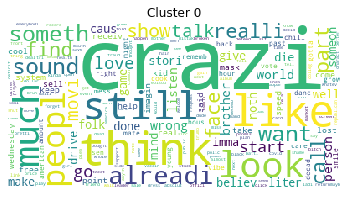

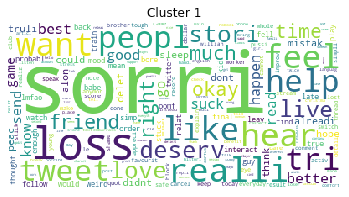

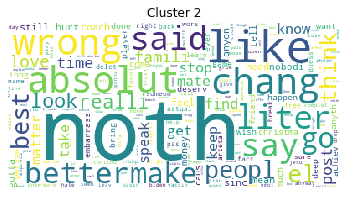

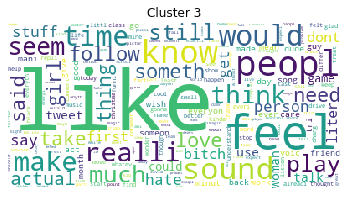

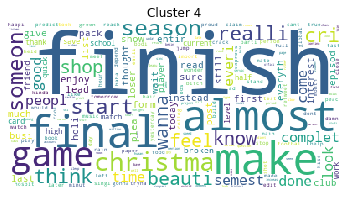

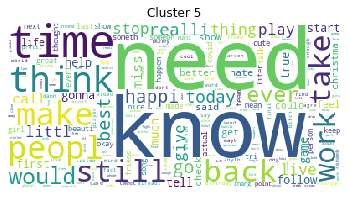

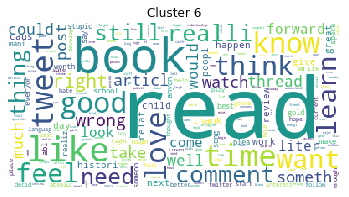

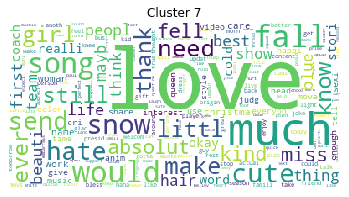

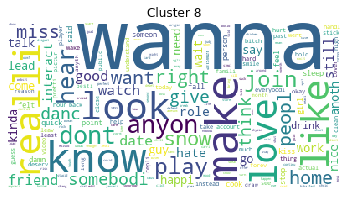

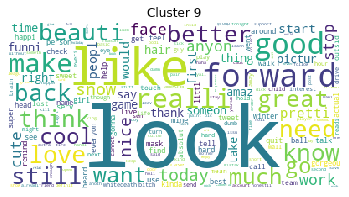

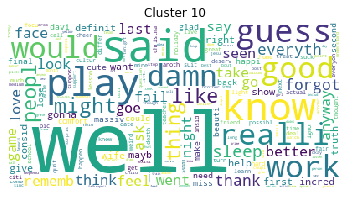

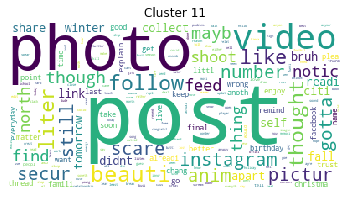

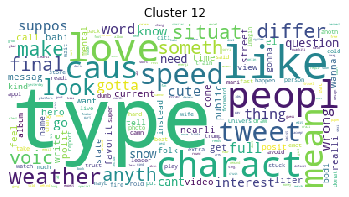

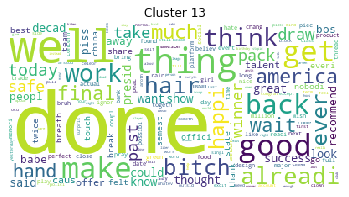

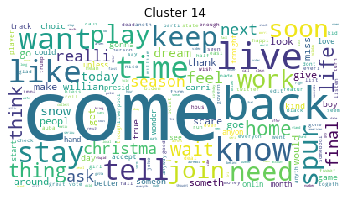

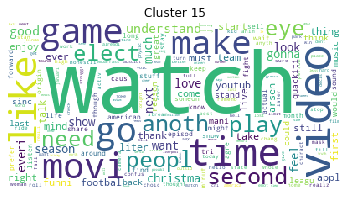

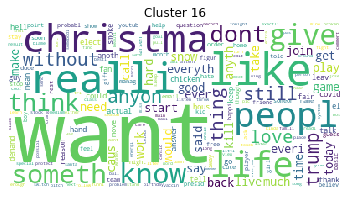

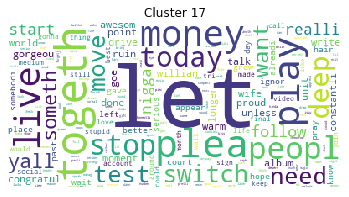

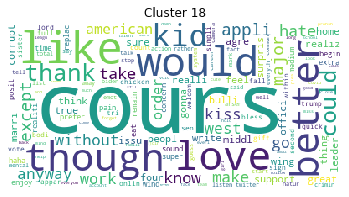

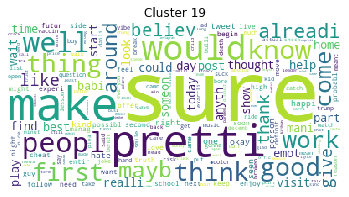

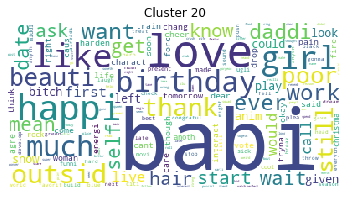

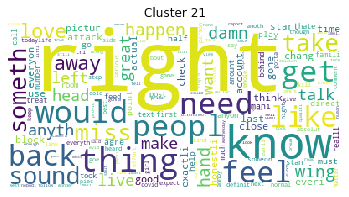

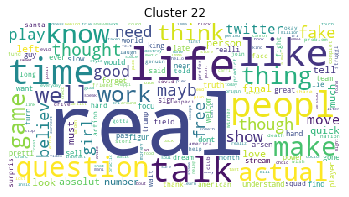

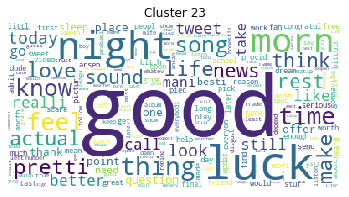

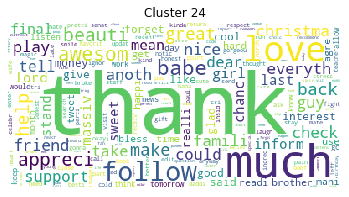

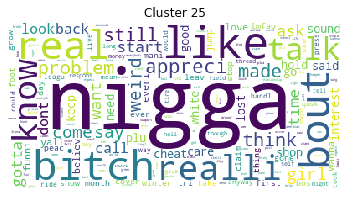

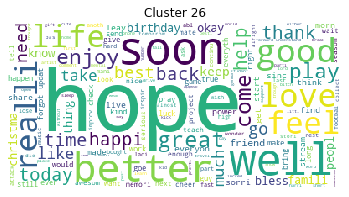

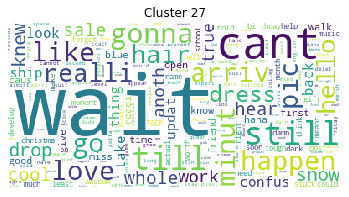

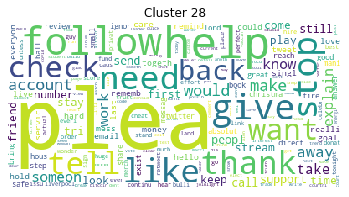

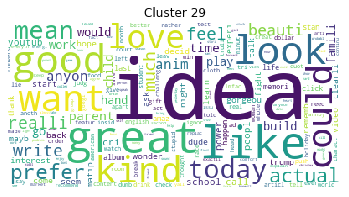

In [96]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = vector.columns
generateWordClouds(centroids)